### Movie Recommendation System
#### By Steven Secreti

What is a `Recommendation System`?
- an algorithm designed to suggest new products to users based on similar products that they had enjoyed in the past

Within this notebook, I will be implementing a movie recommendation system.

Challenges in Recommender Systems (User-Based Collaborative Filtering):
- More people than products, extremely variable taste from person to person
- Tastes change over time

Item-Based Collaborative Filtering:
- Work by recommending elements based on the relationship between *items* instead of people
- Reduces complexity of the problem
- Unlike humans, items do not change over time. A song is a song and a movie is a movie.

#### Goal
- A primary goal of this notebook is to not only create a simple movie recommendation system but to further outline the process of creating **any** recommendation system.
- Markdown cells will be using to outline and differentiate required sections of code

### Recommendation System Steps
##### 0. Init Work:
- Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

- Import Dataset

In [6]:
movie_id_titles = pd.read_csv('movie_id_titles')
movie_id_titles

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [7]:
movies_rating_df = pd.read_csv("u.data", sep='\t', names=["user_id", "item_id", "rating", "timestamp"])
movies_rating_df

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742
...,...,...,...,...
99998,880,476,3,880175444
99999,716,204,5,879795543
100000,276,1090,1,874795795
100001,13,225,2,882399156


##### 1. Preprocessing
- Combine both datasets together, by relational attribute `item-id`

In [8]:
title_dict = {id: title for id, title in zip(movie_id_titles["item_id"], movie_id_titles["title"])}
title_dict

{1: 'Toy Story (1995)',
 2: 'GoldenEye (1995)',
 3: 'Four Rooms (1995)',
 4: 'Get Shorty (1995)',
 5: 'Copycat (1995)',
 6: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 7: 'Twelve Monkeys (1995)',
 8: 'Babe (1995)',
 9: 'Dead Man Walking (1995)',
 10: 'Richard III (1995)',
 11: 'Seven (Se7en) (1995)',
 12: 'Usual Suspects, The (1995)',
 13: 'Mighty Aphrodite (1995)',
 14: 'Postino, Il (1994)',
 15: "Mr. Holland's Opus (1995)",
 16: 'French Twist (Gazon maudit) (1995)',
 17: 'From Dusk Till Dawn (1996)',
 18: 'White Balloon, The (1995)',
 19: "Antonia's Line (1995)",
 20: 'Angels and Insects (1995)',
 21: 'Muppet Treasure Island (1996)',
 22: 'Braveheart (1995)',
 23: 'Taxi Driver (1976)',
 24: 'Rumble in the Bronx (1995)',
 25: 'Birdcage, The (1996)',
 26: 'Brothers McMullen, The (1995)',
 27: 'Bad Boys (1995)',
 28: 'Apollo 13 (1995)',
 29: 'Batman Forever (1995)',
 30: 'Belle de jour (1967)',
 31: 'Crimson Tide (1995)',
 32: 'Crumb (1994)',
 33: 'Desperado (1995)',
 34: '

In [9]:
title_col = movies_rating_df["item_id"].map(title_dict)
title_col

0                        Star Wars (1977)
1         Empire Strikes Back, The (1980)
2               Gone with the Wind (1939)
3                            Kolya (1996)
4                L.A. Confidential (1997)
                       ...               
99998        First Wives Club, The (1996)
99999           Back to the Future (1985)
100000                      Sliver (1993)
100001              101 Dalmatians (1996)
100002                  Unforgiven (1992)
Name: item_id, Length: 100003, dtype: object

In [10]:
#Add title_col to movies_rating_df
movies_rating_df["title"] = title_col
movies_rating_df

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,0,172,5,881250949,"Empire Strikes Back, The (1980)"
2,0,133,1,881250949,Gone with the Wind (1939)
3,196,242,3,881250949,Kolya (1996)
4,186,302,3,891717742,L.A. Confidential (1997)
...,...,...,...,...,...
99998,880,476,3,880175444,"First Wives Club, The (1996)"
99999,716,204,5,879795543,Back to the Future (1985)
100000,276,1090,1,874795795,Sliver (1993)
100001,13,225,2,882399156,101 Dalmatians (1996)


- Drop unneccesary columns

In [11]:
movies_rating_df.drop(["item_id"], axis=1, inplace=True)
movies_rating_df.drop(["timestamp"], axis=1, inplace=True)
movies_rating_df

,user_id,rating,title
0,0,5,Star Wars (1977)
1,0,5,"Empire Strikes Back, The (1980)"
2,0,1,Gone with the Wind (1939)
3,196,3,Kolya (1996)
4,186,3,L.A. Confidential (1997)
...,...,...,...
99998,880,3,"First Wives Club, The (1996)"
99999,716,5,Back to the Future (1985)
100000,276,1,Sliver (1993)
100001,13,2,101 Dalmatians (1996)


- Visualizing Dataset

In [12]:
movies_rating_df.groupby("title").describe()

user_id                                 \
                                        count        mean         std    min   
title                                                                          
'Til There Was You (1997)                 9.0  383.777778  204.272354  152.0   
1-900 (1994)                              5.0  477.000000  244.344020  181.0   
101 Dalmatians (1996)                   109.0  450.330275  295.142779    1.0   
12 Angry Men (1957)                     125.0  453.552000  255.588677    1.0   
187 (1997)                               41.0  517.097561  241.098300    3.0   
...                                       ...         ...         ...    ...   
Young Guns II (1990)                     44.0  504.068182  254.101371   87.0   
Young Poisoner's Handbook, The (1995)    41.0  452.487805  286.352241    7.0   
Zeus and Roxanne (1997)                   6.0  532.833333  343.690219   82.0   
unknown                                   9.0  311.888889  264.160200    1.0   
Á köldum klaka (Cold Fever) (1994)        1.0  655.000000         NaN  655.0   

                                                                  rating  \
                                         25%    50%    75%    max  count   
title                                                                      
'Til There Was You (1997)              223.0  342.0  530.0  782.0    9.0   
1-900 (1994)                           385.0  405.0  581.0  833.0    5.0   
101 Dalmatians (1996)                  183.0  435.0  699.0  938.0  109.0   
12 Angry Men (1957)                    268.0  429.0  661.0  932.0  125.0   
187 (1997)                             416.0  532.0  698.0  894.0   41.0   
...                                      ...    ...    ...    ...    ...   
Young Guns II (1990)                   301.0  459.0  732.5  943.0   44.0   
Young Poisoner's Handbook, The (1995)  246.0  473.0  634.0  936.0   41.0   
Zeus and Roxanne (1997)                251.5  627.5  796.5  881.0    6.0   
unknown                                130.0  297.0  422.0  833.0    9.0   
Á köldum klaka (Cold Fever) (1994)     655.0  655.0  655.0  655.0    1.0   

                                                                           \
                                           mean       std  min   25%  50%   
title                                                                       
'Til There Was You (1997)              2.333333  1.000000  1.0  2.00  2.0   
1-900 (1994)                           2.600000  1.516575  1.0  1.00  3.0   
101 Dalmatians (1996)                  2.908257  1.076184  1.0  2.00  3.0   
12 Angry Men (1957)                    4.344000  0.719588  2.0  4.00  4.0   
187 (1997)                             3.024390  1.172344  1.0  2.00  3.0   
...                                         ...       ...  ...   ...  ...   
Young Guns II (1990)                   2.772727  1.008421  1.0  2.00  3.0   
Young Poisoner's Handbook, The (1995)  3.341463  1.237129  1.0  3.00  4.0   
Zeus and Roxanne (1997)                2.166667  0.983192  1.0  1.25  2.5   
unknown                                3.444444  1.130388  1.0  3.00  4.0   
Á köldum klaka (Cold Fever) (1994)     3.000000       NaN  3.0  3.00  3.0   

                                                 
                                       75%  max  
title                                            
'Til There Was You (1997)              3.0  4.0  
1-900 (1994)                           4.0  4.0  
101 Dalmatians (1996)                  4.0  5.0  
12 Angry Men (1957)                    5.0  5.0  
187 (1997)                             4.0  5.0  
...                                    ...  ...  
Young Guns II (1990)                   3.0  5.0  
Young Poisoner's Handbook, The (1995)  4.0  5.0  
Zeus and Roxanne (1997)                3.0  3.0  
unknown                                4.0  5.0  
Á köldum klaka (Cold Fever) (1994)     3.0  3.0  

[1664 rows x 16 columns]

In [15]:
movies_rating_df.groupby("title").describe()["rating"]

,count,mean,std,min,25%,50%,75%,max
title,,,,,,,,
'Til There Was You (1997),9.0,2.333333,1.000000,1.0,2.00,2.0,3.0,4.0
1-900 (1994),5.0,2.600000,1.516575,1.0,1.00,3.0,4.0,4.0
101 Dalmatians (1996),109.0,2.908257,1.076184,1.0,2.00,3.0,4.0,5.0
12 Angry Men (1957),125.0,4.344000,0.719588,2.0,4.00,4.0,5.0,5.0
187 (1997),41.0,3.024390,1.172344,1.0,2.00,3.0,4.0,5.0
...,...,...,...,...,...,...,...,...
Young Guns II (1990),44.0,2.772727,1.008421,1.0,2.00,3.0,3.0,5.0
"Young Poisoner's Handbook, The (1995)",41.0,3.341463,1.237129,1.0,3.00,4.0,4.0,5.0
Zeus and Roxanne (1997),6.0,2.166667,0.983192,1.0,1.25,2.5,3.0,3.0


- Describing data stats

In [14]:
movies_rating_df.groupby("title").describe()["rating"]["mean"].sort_values(ascending=False)

title
They Made Me a Criminal (1939)                  5.0
Marlene Dietrich: Shadow and Light (1996)       5.0
Saint of Fort Washington, The (1993)            5.0
Someone Else's America (1995)                   5.0
Star Kid (1997)                                 5.0
                                               ... 
Eye of Vichy, The (Oeil de Vichy, L') (1993)    1.0
King of New York (1990)                         1.0
Touki Bouki (Journey of the Hyena) (1973)       1.0
Bloody Child, The (1996)                        1.0
Crude Oasis, The (1995)                         1.0
Name: mean, Length: 1664, dtype: float64

In [18]:
ratings_df_mean = movies_rating_df.groupby("title")["rating"].describe()["mean"]
ratings_df_mean

title
'Til There Was You (1997)                2.333333
1-900 (1994)                             2.600000
101 Dalmatians (1996)                    2.908257
12 Angry Men (1957)                      4.344000
187 (1997)                               3.024390
                                           ...   
Young Guns II (1990)                     2.772727
Young Poisoner's Handbook, The (1995)    3.341463
Zeus and Roxanne (1997)                  2.166667
unknown                                  3.444444
Á köldum klaka (Cold Fever) (1994)       3.000000
Name: mean, Length: 1664, dtype: float64

In [19]:
ratings_df_count = movies_rating_df.groupby("title")["rating"].describe()["count"]
ratings_df_count

title
'Til There Was You (1997)                  9.0
1-900 (1994)                               5.0
101 Dalmatians (1996)                    109.0
12 Angry Men (1957)                      125.0
187 (1997)                                41.0
                                         ...  
Young Guns II (1990)                      44.0
Young Poisoner's Handbook, The (1995)     41.0
Zeus and Roxanne (1997)                    6.0
unknown                                    9.0
Á köldum klaka (Cold Fever) (1994)         1.0
Name: count, Length: 1664, dtype: float64

In [21]:
#Combine the two dataframes
ratings_df = pd.concat([ratings_df_mean, ratings_df_count], axis=1).reset_index()
ratings_df

,title,mean,count
0,'Til There Was You (1997),2.333333,9.0
1,1-900 (1994),2.600000,5.0
2,101 Dalmatians (1996),2.908257,109.0
3,12 Angry Men (1957),4.344000,125.0
4,187 (1997),3.024390,41.0
...,...,...,...
1659,Young Guns II (1990),2.772727,44.0
1660,"Young Poisoner's Handbook, The (1995)",3.341463,41.0
1661,Zeus and Roxanne (1997),2.166667,6.0
1662,unknown,3.444444,9.0


- Plot histogram of ratings

<AxesSubplot:ylabel='Frequency'>

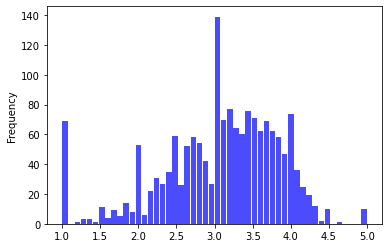

In [28]:
ratings_df["mean"].plot(bins=50, kind="hist", color='blue', alpha=0.7, rwidth=0.9)

<AxesSubplot:ylabel='Frequency'>

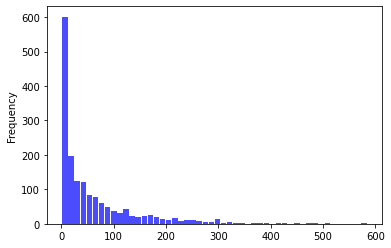

In [29]:
ratings_df["count"].plot(bins=50, kind="hist", color='blue', alpha=0.7, rwidth=0.9)

In [30]:
ratings_df[ ratings_df["mean"] == 5 ]

,title,mean,count
30,Aiqing wansui (1994),5.0,1.0
462,Entertaining Angels: The Dorothy Day Story (1996),5.0,1.0
633,"Great Day in Harlem, A (1994)",5.0,1.0
944,Marlene Dietrich: Shadow and Light (1996),5.0,1.0
1172,Prefontaine (1997),5.0,3.0
1273,"Saint of Fort Washington, The (1993)",5.0,2.0
1277,Santa with Muscles (1996),5.0,2.0
1359,Someone Else's America (1995),5.0,1.0
1387,Star Kid (1997),5.0,3.0
1472,They Made Me a Criminal (1939),5.0,1.0


In [31]:
ratings_df.sort_values('count', ascending=False)

,title,mean,count
1398,Star Wars (1977),4.359589,584.0
333,Contact (1997),3.803536,509.0
498,Fargo (1996),4.155512,508.0
1234,Return of the Jedi (1983),4.007890,507.0
860,Liar Liar (1997),3.156701,485.0
...,...,...,...
633,"Great Day in Harlem, A (1994)",5.000000,1.0
1111,"Other Voices, Other Rooms (1997)",3.000000,1.0
620,Good Morning (1971),1.000000,1.0
606,Girls Town (1996),3.000000,1.0


##### 2: Item-Based Collaborative Filtering
- Perform item-based collaborative filtering on one movie sample

- Create a matrix associating each user with the movies they have watched

In [33]:
#Powerful tool to convert dataframe to a two-dimensional array
user_movie_matrix = movies_rating_df.pivot_table(index="user_id", columns="title", values="rating")
user_movie_matrix

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Plotting the ratings for a single movie

In [35]:
titanic = user_movie_matrix['Titanic (1997)']
titanic

user_id
0      NaN
1      NaN
2      5.0
3      NaN
4      NaN
      ... 
939    NaN
940    5.0
941    NaN
942    3.0
943    NaN
Name: Titanic (1997), Length: 944, dtype: float64

In [54]:
titanic_correlations = pd.DataFrame(user_movie_matrix.corrwith(titanic), columns=["Correlation"]).reset_index()
titanic_correlations

c:\Python310\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Python310\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


,title,Correlation
0,'Til There Was You (1997),-0.062017
1,1-900 (1994),NaN
2,101 Dalmatians (1996),0.120113
3,12 Angry Men (1957),0.077700
4,187 (1997),0.315654
...,...,...
1659,Young Guns II (1990),0.317274
1660,"Young Poisoner's Handbook, The (1995)",0.356783
1661,Zeus and Roxanne (1997),NaN
1662,unknown,NaN


In [55]:
titanic_correlations = titanic_correlations.join(ratings_df['count'], how='left')
titanic_correlations

,title,Correlation,count
0,'Til There Was You (1997),-0.062017,9.0
1,1-900 (1994),NaN,5.0
2,101 Dalmatians (1996),0.120113,109.0
3,12 Angry Men (1957),0.077700,125.0
4,187 (1997),0.315654,41.0
...,...,...,...
1659,Young Guns II (1990),0.317274,44.0
1660,"Young Poisoner's Handbook, The (1995)",0.356783,41.0
1661,Zeus and Roxanne (1997),NaN,6.0
1662,unknown,NaN,9.0


- Drop NaN

In [56]:
titanic_correlations.dropna(inplace=True)
titanic_correlations

,title,Correlation,count
0,'Til There Was You (1997),-0.062017,9.0
2,101 Dalmatians (1996),0.120113,109.0
3,12 Angry Men (1957),0.077700,125.0
4,187 (1997),0.315654,41.0
5,2 Days in the Valley (1996),0.017295,93.0
...,...,...,...
1655,Year of the Horse (1997),1.000000,7.0
1657,Young Frankenstein (1974),0.107666,200.0
1658,Young Guns (1988),0.199931,101.0
1659,Young Guns II (1990),0.317274,44.0


In [58]:
titanic_correlations.sort_values('Correlation', ascending=False)

,title,Correlation,count
1038,Nadja (1994),1.0,8.0
1140,"Pest, The (1997)",1.0,8.0
1278,"Savage Nights (Nuits fauves, Les) (1992)",1.0,3.0
541,For Ever Mozart (1996),1.0,3.0
779,"Jerky Boys, The (1994)",1.0,3.0
...,...,...,...
1130,Pather Panchali (1955),-1.0,8.0
72,Angel Baby (1995),-1.0,4.0
189,Blood Beach (1981),-1.0,6.0
1548,Two Bits (1995),-1.0,5.0


- Show only other movies that have been rated at least 80 times

In [59]:
titanic_correlations[titanic_correlations["count"] > 80].sort_values('Correlation', ascending=False)

,title,Correlation,count
1500,Titanic (1997),1.000000,350.0
1244,"River Wild, The (1994)",0.497600,146.0
16,"Abyss, The (1989)",0.472103,151.0
223,Bram Stoker's Dracula (1992),0.443560,120.0
1533,True Lies (1994),0.435104,208.0
...,...,...,...
226,Brazil (1985),-0.243532,208.0
1238,Richard III (1995),-0.275451,89.0
321,Cold Comfort Farm (1995),-0.307150,125.0
1558,"Unbearable Lightness of Being, The (1988)",-0.314476,92.0


##### 5. Item-Based Collaborative Filter Entire Dataset

In [60]:
user_movie_matrix

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
movie_correlations = user_movie_matrix.corr(method="pearson", min_periods=80)
movie_correlations

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-900 (1994),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.178848,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187 (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Young Guns II (1990),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Young Poisoner's Handbook, The (1995)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zeus and Roxanne (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
myRatings = pd.read_csv("My_Ratings.csv")
myRatings

,Movie Name,Ratings
0,Liar Liar (1997),5
1,Star Wars (1977),1


In [69]:
similar_movies_list = pd.Series(dtype='float64')
for movie, rating in zip(myRatings["Movie Name"], myRatings["Ratings"]):
    similar_movies = movie_correlations[movie].dropna()
    #Scale similarity from rating
    similar_movies = similar_movies.map(lambda x: x * rating)
    similar_movies_list = similar_movies_list.append(similar_movies)
similar_movies_list.sort_values(inplace=True, ascending=False)
similar_movies_list


C:\Users\steve\AppData\Local\Temp\ipykernel_30468\1940093192.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies_list = similar_movies_list.append(similar_movies)
C:\Users\steve\AppData\Local\Temp\ipykernel_30468\1940093192.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies_list = similar_movies_list.append(similar_movies)


Liar Liar (1997)                                                               5.000000
Con Air (1997)                                                                 2.349141
Pretty Woman (1990)                                                            2.348951
Michael (1996)                                                                 2.210110
Indiana Jones and the Last Crusade (1989)                                      2.072136
                                                                                 ...   
Leaving Las Vegas (1995)                                                      -0.686991
Fantasia (1940)                                                               -0.739094
This Is Spinal Tap (1984)                                                     -0.791064
Brazil (1985)                                                                 -0.806306
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)   -1.190462
Length: 574, dtype: float64